## Classificació d'imatges - Xarxes Neuronals i Aprenentatge profund
## Dogs breed classifier


**Biel González Garriga    NIU: 1551813** 

**Sofia DiCapua --    NIU: 1603685** 

**Cristina Soler Arenys    NIU: 1603542**

Aquest quadern de Jupyter té com objectiu presentar els resultats obtinguts en el nostre projecte seguint els passos que hem anat completant. Totes les funcions que s'han usat les podreu trobar al github repartides en diferents scripts de python. Per poder entrenar models o provar-los s'haurà d'accedir al fitxer `main.py`. Altrament, per poder executar els scripts l'usuari ha de descarregar les dades de les imatges i guardar-les amb una carpeta, amb nom `Dogs-Breed-class` dins el projecte, d'aquesta maners assegurem un funcionament correcte.

**Índex**   
1. [Descripció de les dades](#id1)
2. [Importar les dades](#id2)
3. [Tractament de les dades](#id3)
4. [Entrenament amb model CNN - no preentrenat](#id4)
5. [Entrenament amb model CNN - preentrenat](#id5)
6. [Diferents formes d'entrenament](#id6)
7. [Aplicació en diferents dades](#id7)
8. [Test dels resultats](#id8)
9. [Evaluació qualitativa i quantitativa](#id9)


### Descripció de les dades<a name="id1"></a>
Se'ns proporciona una base de dades que ens permet fer la classificació de 120 raçes de gossos diferents, a partir d'imatges. Cada imathe té un nom de fitxer que és el seu identificador únic. L'objectiu és ccrear un classificador capaç de reconeixer i determinar la raça d'un gos a partir d'una foto.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\cristina soler\Documents\UNIVERSITAT programes\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
labels = pd.read_csv('Dog-Breed-classif/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Com podem observar disposem de 10222 imatges de test

In [6]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


Mirem com estaran distribuïdes les imatges segons les raçes per si n'hi ha alguna que predomini per sobre les altres i pogues provocar que l'entrenament s'esbiaixes. Com podem observar a la següent gràfica, la raça de gos amb més imatges és `scottish_deerhound` i el que menys `briard`, però la diferència d'imatges entre aquestes dues no creiem que pugui suposar un problema a l'hora d'entrenar

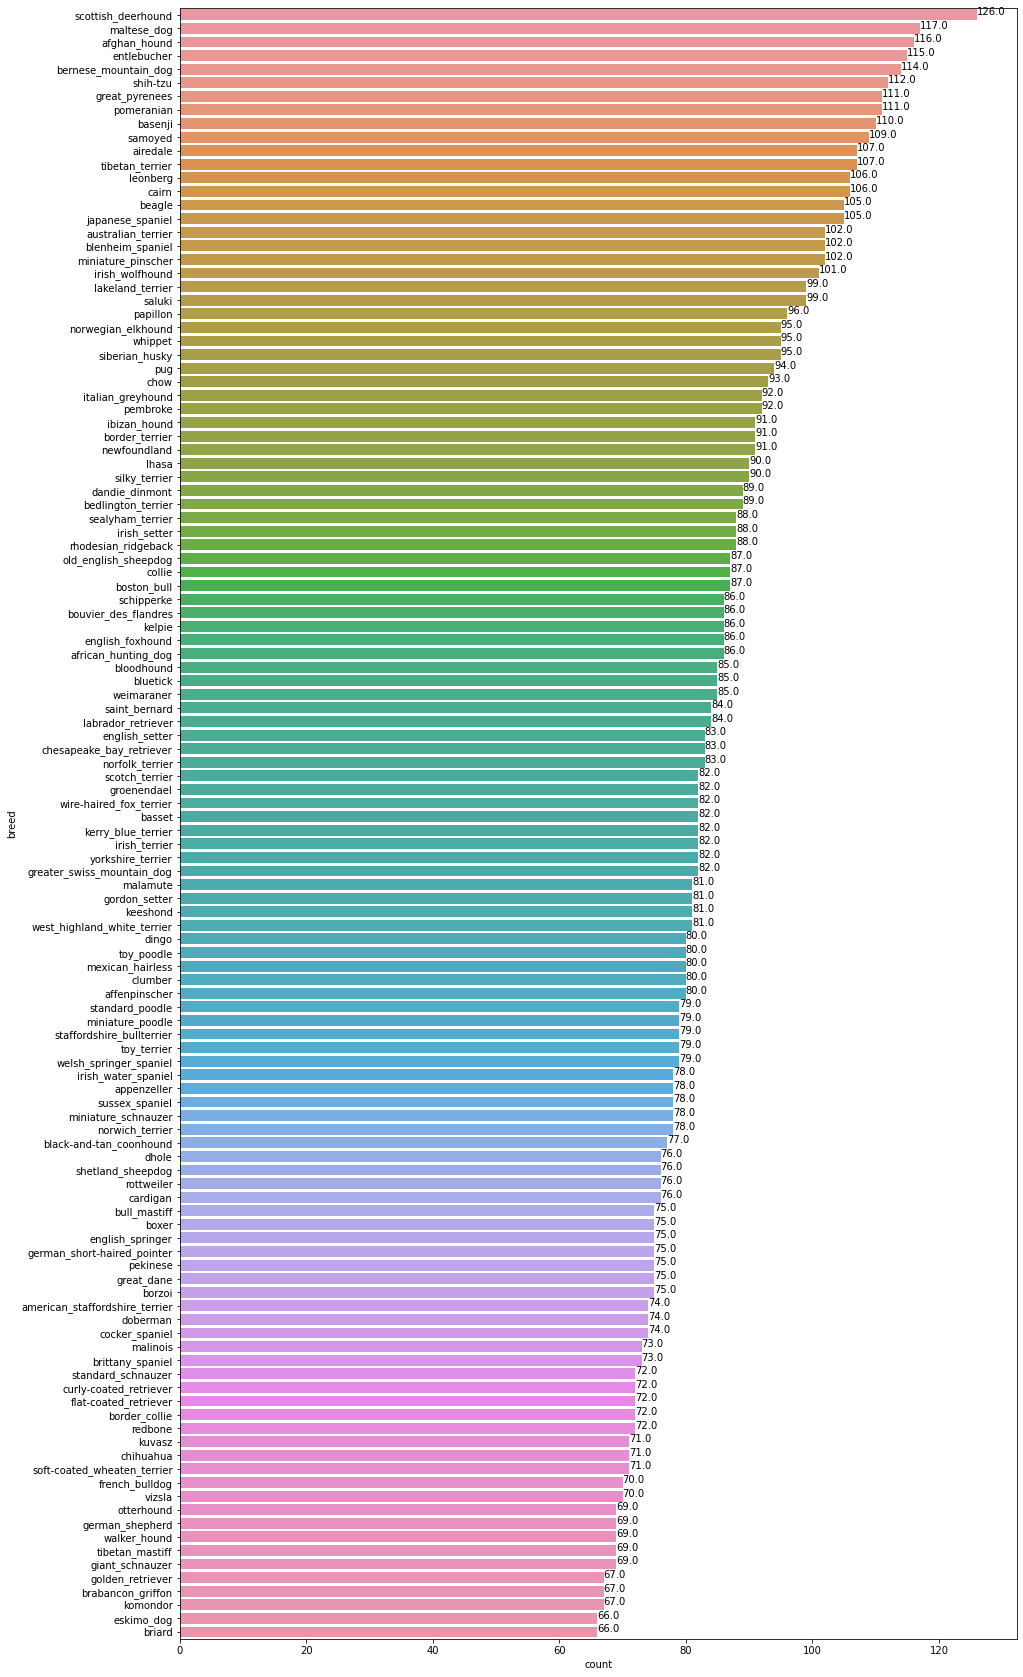

In [7]:
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

### Importar les dades<a name="id2"></a>

A la importació de les dades es important tenir descarregat el dataset que se'ns proporciona des de Kaggle i guardat dins una carpeta amb nom `Dogs-Breed-class`.

L'estructura de la carpeta de dades és la següent:
- `\train`: Trobarem les imatges que usarem en el train
- `\test`: Trobarem les imatges per fer proves, no podrem fer una comparació d'accuracy amb aquestes dades ja que no disposem dels valors dels labels reals.
- `labels.csv`: Arxiu csv on trobarem els identificadors de cada imatge amb la raça de gos correponent

Primerament, l'script que s'executarà és el de `FolderClassification.py` (el podeu trobar dins la carpeta de Data). Aquest script, crea carpetes amb noms de les raçes de gos, i ens organitza les imatges de train classificant-les dins la carpeta del nom de raça que li pertoca. Al fer aquest pas, se'ns facilita generar els dataloaders amb la classe propia de pytorch.


Un cop ja tenim les dades preparades, aplicarem el dataloader el que ens permetrà carregar les imatge i per posteriorment utilitzar-les en els nostres models. L'script que s'executarà es troba dins la carpeta Utils (`DataLoaders.py`). En aquest punt les nostres dades provinents de la carpeta de `train`quedan separades en 3 subsets de manera aleatoria. És a dir tindrem el subset: `train`, `val` i `test`, els quals ens permetran fer l'entrenament i mirar quina accuracy aconseguim.

### Tractament de les dades<a name="id3"></a>

El tractament que hem aplicat a les dades com a transformacions per poder entrenar els models són els següents:
- **Transformació 1 (bàsica):** Aquesta transformació és la més bàsica de totes, ja que apliquem les transformacions de resize a la input específicada de 224, centrem la imatge i finalment convertim a tensor i apliquem una normalització a les dades. Aquesta transformació ve donada per la mitjana i la desviació estàndar de les imatges.
- **Transformació 2 (Grey scale):** Tal com indica el nom aquesta transformació converteix en escala de grisos les imatges.
- **Transformació 3 (Complete one):** Podriem dir que és la més completa de totes. A la transformació 1 li afegirem un random flip tan vertical com horitzontal amb probabilitat 0.5, juntament amb un gaussian blur.
- **Transformació 4 (Jitter):** Afegim un jitter a la transformació 1, el que provocarà a la imatge que el color canviï 

In [17]:
from PIL import Image
from torchvision import transforms
img_example=Image.open("./Dog-Breed-classif/test/00a3edd22dc7859c487a64777fc8d093.jpg")
input_size = 224
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

def Show_Image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


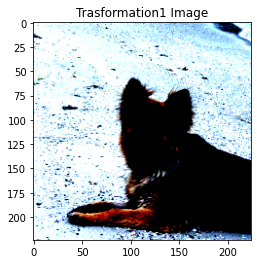

In [25]:
#Transformation 1 (Basic)
data_transforms_basic = transforms.Compose([
        transforms.Resize(input_size), #Resize the image to the specified input size
        transforms.CenterCrop(input_size), #Center crop the image
        transforms.ToTensor(), #Convert to tensor Pytorch tensor
        normalize #Apply the normalize
    ])
T1 = data_transforms_basic(img_example)
Show_Image(T1.permute(1, 2, 0), 'Trasformation1 Image')

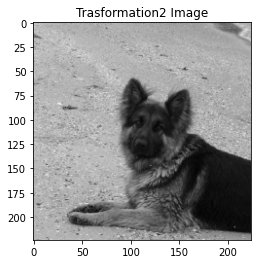

In [26]:
#Transformation 2 (Grey Scale)
data_transforms_gray_scale = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Grayscale(3), #Convert the image to grey scale output channels 3, RGB but in gray scale
        transforms.ToTensor() #Convert to tensor Pytorch tensor
    ])
T2 = data_transforms_gray_scale(img_example)
Show_Image(T2.permute(1, 2, 0), 'Trasformation2 Image')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


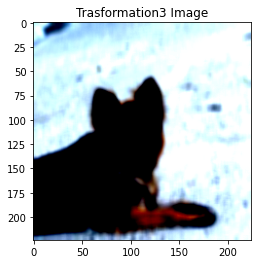

In [27]:
#Transformation 3 (Complete one)
data_transforms_complete =  transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomVerticalFlip(p=0.5), #Random flip the image vertically with a probablity of 0.5
        transforms.RandomHorizontalFlip(p=0.5), #Random flip the image horizontally with a probablity of 0.5
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # Apply Gaussian blur to the image
        transforms.ToTensor(),
        normalize
    ])
T3 = data_transforms_complete(img_example)
Show_Image(T3.permute(1, 2, 0), 'Trasformation3 Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


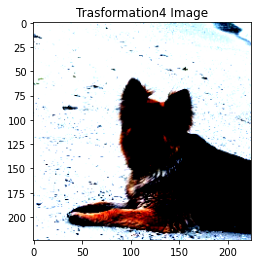

In [29]:
#Transformation 4 (jitter)
data_transforms_jitter = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ColorJitter(brightness=.5, hue=.3), # Apply color jitter to the image
        transforms.ToTensor(),
        normalize
    ])
T4 = data_transforms_jitter(img_example)
Show_Image(T4.permute(1, 2, 0), 'Trasformation4 Image')

### Entrenament amb model CNN - no preentrenat<a name="id4"></a>

Durant les primeres proves vam decidir entrenar el nostre model a partir d'un model fet per nosaltres en scratch. El model que vam provar va ser un CNN bàsic el qual s'ens havia proporcionat alguna entrega setmanal:

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Els resultats que vam obtenir van ser catastrófics amb una accuracy de 0.03 com a màxim, és a dir podriem triar aleatoriament la raça del gos i tindriem més probabilitats d'endivinar-la que la xarxa. Vam arribar a la conclusió que aixó passava ja que tot i que disposem de deu mil imatges per realitar l'entrenament, no són suficients perquè la xarxa aprengui les 120 raçes diferents. Al obtenir aquests resultats vam preferir passar a entrenar amb xarxes ja preentrenades.

### Entrenament amb model CNN - preentrenat<a name="id5"></a>

Pytorch dona la opció de fer servir models que ja han estat entrenats, el que fàcilita i ajuda que el model doni millors resultats amb les imatges. Els models seleccionats són amb els seus resultats:

- initialize_model_resnet_18: 
- initialize_model_resnext101_64x4d: 
- initialize_model_resnext101_32x8d: 
- initialize_model_resnext50_32x4d: 

### Diferents formes d'entrenament<a name="id6"></a>

### Aplicació en diferents dades<a name="id7"></a>

Per obtenir més dades d'entrenament vam decidir eliminar el fons a les imatges i mirar si la xarxa millorava les prediccions. 

Cal destacar que l'entrenament amb aquestes imatges és nefast amb una accuracy molt i molt baixa per tant no podem tenir en compte les dades per entrenar la xarxa. El que si que succeix és que la xarxa respon correctament aquestes imatges ja que únicament visualitza el gos i provoca que la predicció sigui molt més bona.

El codi usat per treure el fons a les imatges és el següent:

### Test dels resultats<a name="id8"></a>

Provarem els resultats de les diferents xarxes preentrenades amb la mateixa imatge, per visualitzar quins són els resultats que ens donen i quina ens dona millors valors:

In [8]:
import torchvision
import torch.nn as nn
import torch

def initialize_model_resnext101_64x4d(num_classes):
    model = torchvision.models.resnext101_64x4d()
    model.fc = nn.Linear(2048, num_classes)
    input_size = 224

    return model

def initialize_model_resnext101_32x8d(num_classes):
    model = torchvision.models.resnext101_32x8d()
    model.fc = nn.Linear(2048, num_classes)
    input_size = 224

    return model

In [9]:
def predict(image, model):
    """Return top 5 predictions ranked by highest probability.

    Parameters
    ----------
    :param image: uploaded image
    :type image: jpg
    :rtype: list
    :return: top 5 predictions ranked by highest probability
    """   
    # transform the input image through resizing, normalization
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )])

    batch_t = torch.unsqueeze(transform(image), 0)
    #Evaluem en model amb la imatge i mirem els resultats
    model.eval()
    out = model(batch_t)

    with open('datos.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    # return the top 5 predictions ranked by highest probabilities
    prob = torch.nn.functional.softmax(out, dim = 1)[0] * 100
    _, indices = torch.sort(out, descending = True)
    return [(classes[idx], prob[idx].item()) for idx in indices[0][:5]]

In [10]:
model2 = initialize_model_resnext101_32x8d(120)
device = torch.device('cpu')
model2.load_state_dict(torch.load("./ResNext101_32x8d_PreTrained.pth", device))

<All keys matched successfully>

In [11]:
model1 = initialize_model_resnext101_64x4d(120)
device = torch.device('cpu')
model1.load_state_dict(torch.load("./ResNext101_64x4d_PreTrained.pth", device))

<All keys matched successfully>

La imatge que volem predir és la següent, d'on podem intuïr que és un pastor alemany:

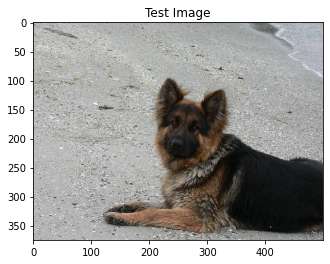

In [16]:
image = Image.open("./Dog-Breed-classif/test/00a3edd22dc7859c487a64777fc8d093.jpg")
Show_Image(image, 'Test Image')

In [97]:
labels = predict(image, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: german_shepherd ----> Score: 36.6650276184082
Name: malinois ----> Score: 4.977924346923828
Name: leonberg ----> Score: 3.3227670192718506
Name: kelpie ----> Score: 1.5488559007644653
Name: norwegian_elkhound ----> Score: 1.3096625804901123

resnext_101_32x8d
Name: german_shepherd ----> Score: 96.69499206542969
Name: airedale ----> Score: 1.4109132289886475
Name: leonberg ----> Score: 0.28958478569984436
Name: tibetan_mastiff ----> Score: 0.15077580511569977
Name: malinois ----> Score: 0.1436915099620819


Com podem observar el model `resnext_101_32x8d` és el que millors resultats ens proporciona, ja que ens dona la puntuació del pastor alemany amb gairebe 100% de score. Per tant, dels dos models amb millor resultats podriem dir que el millor es el de 32x8d. Realitzem diverses proves més amb imatges on el gos no es el primer pla o hi han diversos objectes més que podrien confondre la xarxa.

In [13]:
image2 = Image.open("./Dog-Breed-classif/test/0b69acfc61048e94c7ba772a1f55012b.jpg")
image3 = Image.open("./Dog-Breed-classif/test/0bd08711dd75d82507a002b300f9fc61.jpg")

AttributeError: type object 'Image' has no attribute 'open'

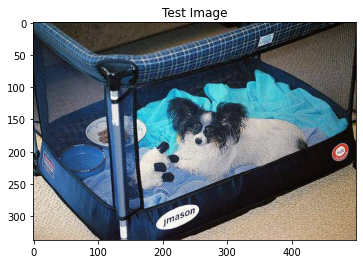

In [99]:
Show_Image(image2, 'Test Image')

In [100]:
labels = predict(image2, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image2, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: papillon ----> Score: 71.97412109375
Name: japanese_spaniel ----> Score: 0.9904080033302307
Name: toy_terrier ----> Score: 0.7378261685371399
Name: pomeranian ----> Score: 0.5376613736152649
Name: great_pyrenees ----> Score: 0.44738250970840454

resnext_101_32x8d
Name: papillon ----> Score: 97.49748229980469
Name: border_collie ----> Score: 0.5557440519332886
Name: collie ----> Score: 0.3281320333480835
Name: toy_terrier ----> Score: 0.2620323896408081
Name: shetland_sheepdog ----> Score: 0.22812420129776


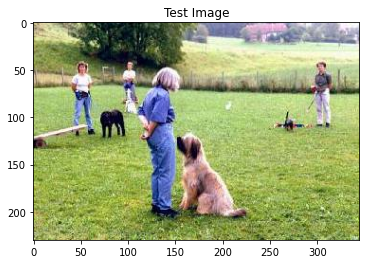

In [103]:
Show_Image(image3, 'Test Image')

In [104]:
labels = predict(image3, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image3, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: otterhound ----> Score: 21.46553611755371
Name: leonberg ----> Score: 8.127409934997559
Name: briard ----> Score: 3.9384920597076416
Name: bouvier_des_flandres ----> Score: 3.12921404838562
Name: afghan_hound ----> Score: 3.0986456871032715

resnext_101_32x8d
Name: otterhound ----> Score: 37.17274856567383
Name: silky_terrier ----> Score: 17.18016242980957
Name: english_setter ----> Score: 9.244747161865234
Name: briard ----> Score: 7.422240734100342
Name: bluetick ----> Score: 3.8866214752197266


#### Imatges sense fons

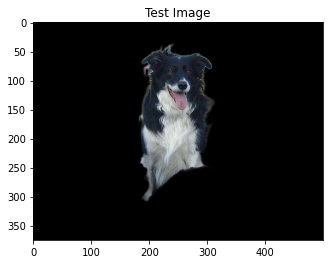

In [107]:
imagesnsfons = Image.open("./0adfec2804a1efe41f54758cd87cec01.jpg").convert('RGB')
Show_Image(imagesnsfons, 'Test Image')

In [108]:
labels = predict(imagesnsfons, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(imagesnsfons, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: border_collie ----> Score: 20.040008544921875
Name: collie ----> Score: 8.201828956604004
Name: leonberg ----> Score: 3.386995553970337
Name: dhole ----> Score: 2.3536572456359863
Name: airedale ----> Score: 1.9846988916397095

resnext_101_32x8d
Name: border_collie ----> Score: 93.31023406982422
Name: collie ----> Score: 6.031479835510254
Name: boston_bull ----> Score: 0.10439387708902359
Name: appenzeller ----> Score: 0.07250525802373886
Name: borzoi ----> Score: 0.06792841851711273


### Web interactiva
D'altra banda, per provar els resultats de la nostre xarxa hem creat un aplicatiu amb streamlit una plataforma d'internet pensada i plantejada per crear aplicacions de python. El que ens permet la nostre pàgina és que l'usuari penji una imatge del que vulgui i la xarxa predirà si es un gos o no, i si ho és ens dirà a quina raça pertany. A més a més ens indicarà quins són els valors amb millor score de la xarxa.

Hem decidit fer l'aplicatiu per poder acostar al usuari el nostre projecte, ja que aquesta seria la part més interactiva.

L'enllaç directe a la pàgina web: https://kermitsc7-dog-breed-dogapp-inaxrc.streamlit.app

### Evaluació qualitativa i quantitativa<a name="id9"></a>

I per últim però no menys important, l'evaluació dels nostres models. En aquest apartat no evaluarem només com de bé classifican els nostres models sino també com els models han entes les imatges. Per la primera part utilitzarem matrius de confusió, que exposen de manera clara i visual la quantitat de classificacions correctament e incorrectament realitzades. Per la segona, emprearem l'algorisme LIME (Local Interpretable Model-Agnostic Explanations) que mostra el blackbox que hi ha dins l'entendiment dels models.

#### Matrius de confusió

In [31]:
from sklearn.metrics import multilabel_confusion_matrix
mtx = (multilabel_confusion_matrix(y_testing,y_predict))
print(mtx)

NameError: name 'y_testing' is not defined

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_testing,y_predict))

In [ ]:
def generalize_cfmatrix(cf_matrix, num_groups):
    gen_cfmatrix = np.zeros((num_groups, num_groups))
    T = np.zeros(num_groups)

    for col in range(len(cf_matrix)):
        for row in range(len(cf_matrix[0])):
            # find gen_i, gen_j
            for k in range(1, num_groups + 1):
                if (col < len(cf_matrix) / num_groups * k and
                        col >= len(cf_matrix) / num_groups * (k - 1)):
                    gen_i = k - 1
                if (row < len(cf_matrix) / num_groups * k and
                        row >= len(cf_matrix) / num_groups * (k - 1)):
                    gen_j = k - 1
            gen_cfmatrix[gen_i][gen_j] += cf_matrix[col][row]
            if col == row:
                T[gen_i] += cf_matrix[col][row]
    
    # distribute false values to neighbor columns
    for col in range(len(gen_cfmatrix)):
        for row in range(len(gen_cfmatrix[0])):
            if col == row:
                F = gen_cfmatrix[col][row] - T[col]
                gen_cfmatrix[col][row] -= F
                if row == 0:
                    gen_cfmatrix[col][row+1] += F
                elif row == len(gen_cfmatrix) - 1:
                    gen_cfmatrix[col][row-1] += F
                else:
                    F1 = int(F/2)
                    F2 = F - F1
                    gen_cfmatrix[col][row-1] += F1
                    gen_cfmatrix[col][row+1] += F2
    return gen_cfmatrix

num_groups = 6
gen_cfmatrix = generalize_cfmatrix(original_cf_matrix, num_groups)
print(gen_cfmatrix)

#### LIME

## Feature extraction

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
 
from torch.utils.data import  DataLoader
from torchvision import models
 
import torchvision.transforms as transforms
import torchvision.datasets as dataset
 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

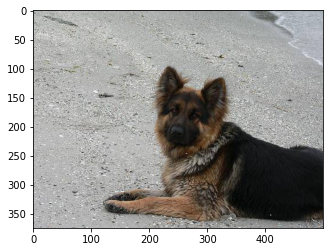

torch.Size([1, 3, 224, 224])


In [21]:
plt.imshow(image)
plt.show()
 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img=np.array(image)
img=transform(img)
img=img.unsqueeze(0)
print(img.size())

**resnext_101_32x8d**

In [24]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model2.children())
 
for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)

1


In [25]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


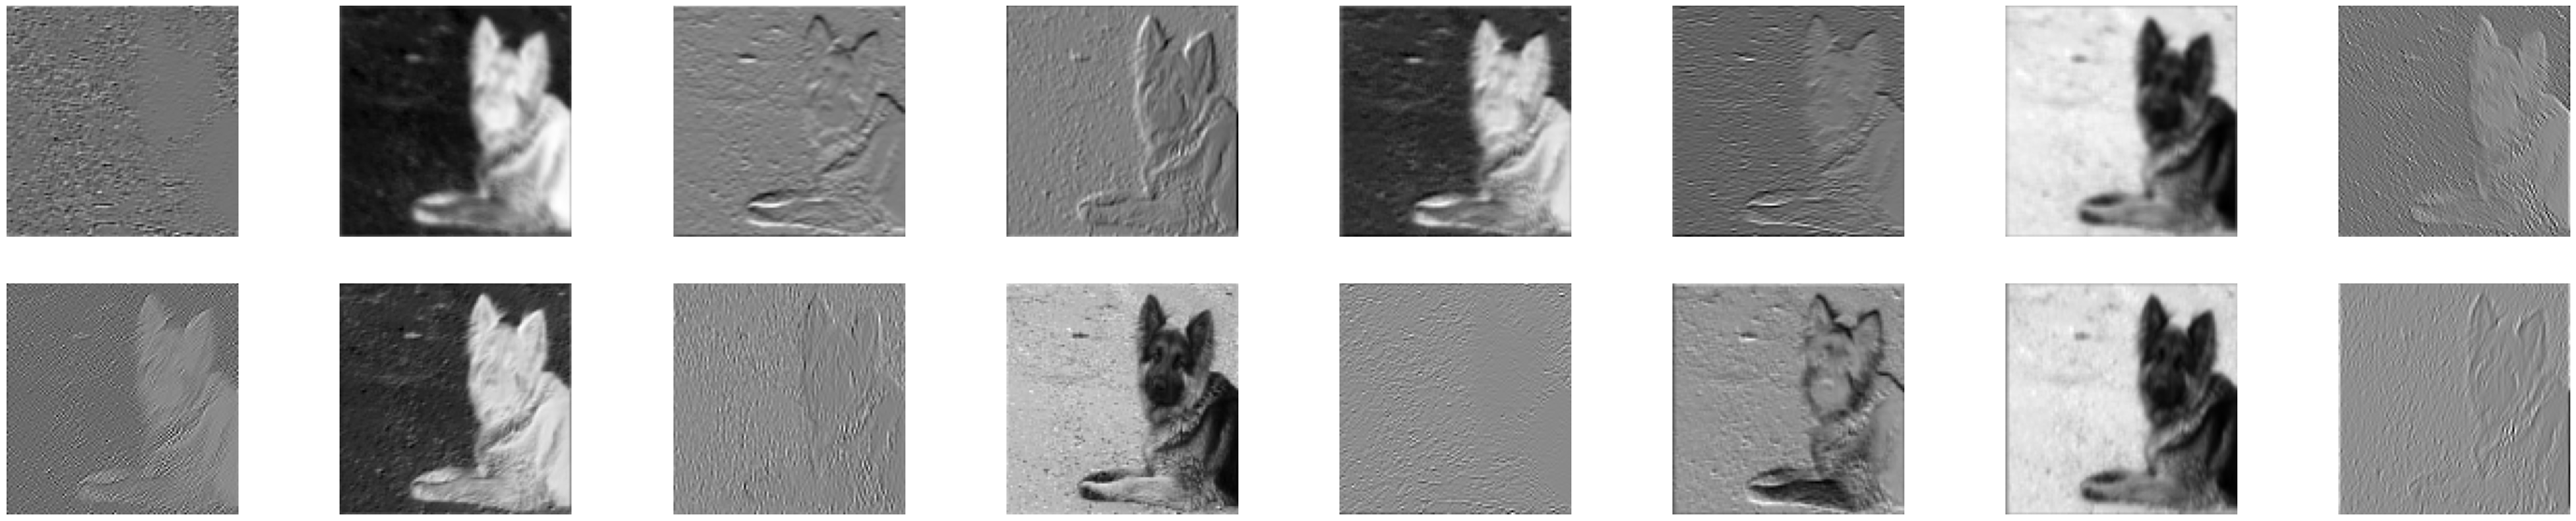

In [26]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

**resnext_101_64x4d**

In [27]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model1.children())
 
for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)

1


In [28]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


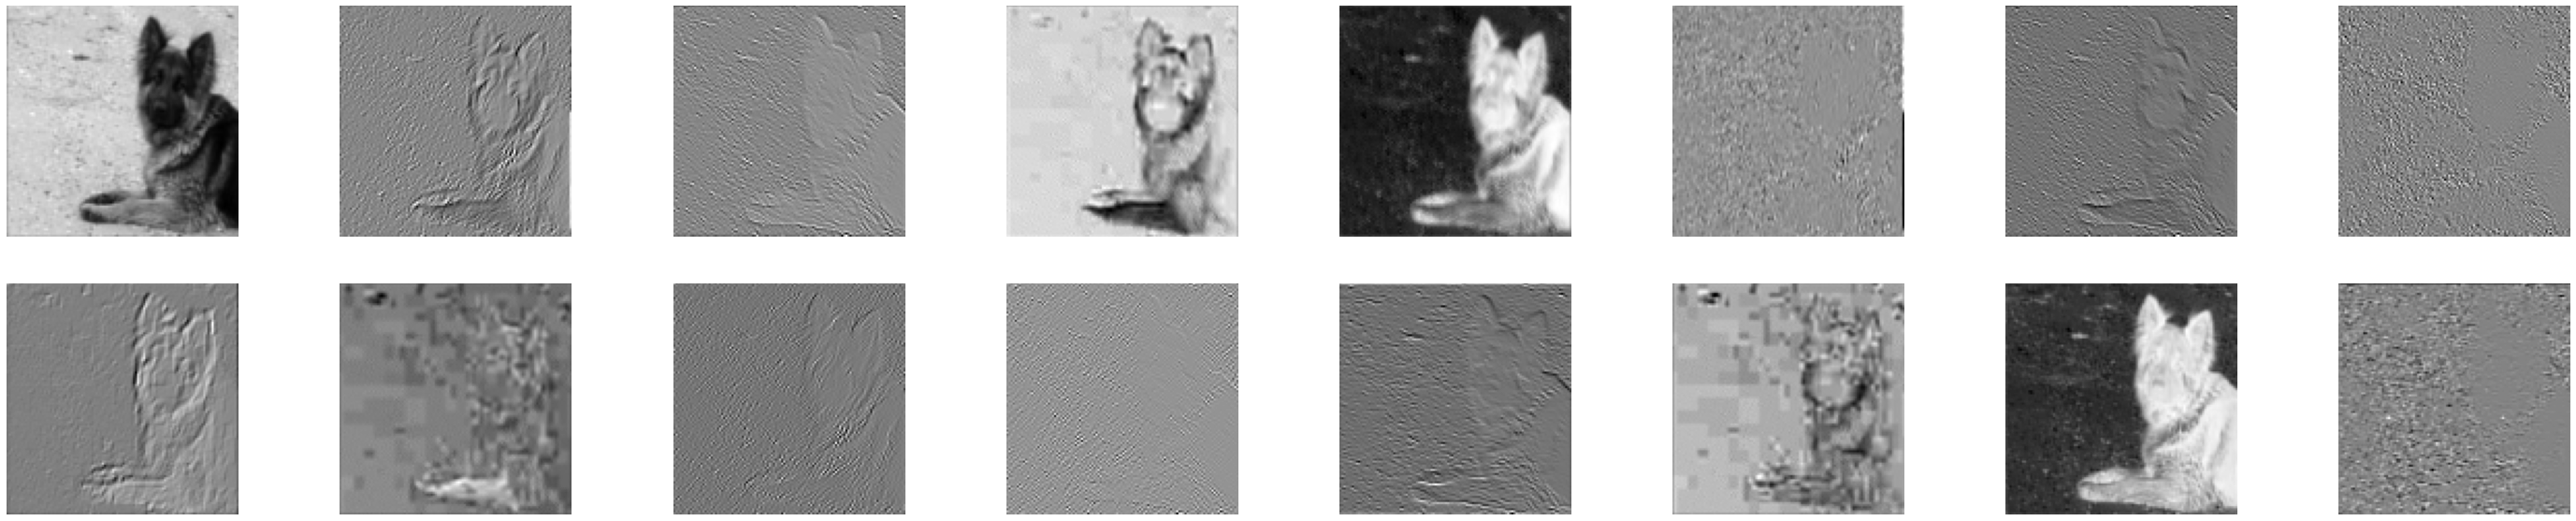

In [29]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()